# Measuring the Hubble Constant (H₀) with Type Ia Supernovae

**A hands-on tutorial: frequentist and Bayesian approaches**

This notebook walks you through estimating the Hubble constant, $H_0$, from low-redshift Type Ia Supernovae (SNe Ia). We'll:

1. Review the low-$z$ Hubble-law approximation and the SN distance-modulus relation.
2. Generate a realistic synthetic SN sample (or load your own data).
3. Estimate $H_0$ with a frequentist $\chi^2$ fit, including bootstrap uncertainty.
4. Do Maximum-Likelihood estimator for another frequentist approach.
4. Do a Bayesian inference on a grid with sensible priors, and marginalize to obtain $p(H_0\,|\,\mathrm{data})$ (no Cobaya, emcee, Nautilus or any other famous sampler!)
5. Visualize the Hubble diagram, residuals, likelihoods, and posteriors.

The tutorial keeps the cosmology deliberately simple and focuses on the statistics. For real analyses you would:
- Use calibrated absolute magnitudes from independent distance ladders (e.g., Cepheids, TRGB).
- Model peculiar-velocity and selection effects carefully.
- Use full cosmological luminosity distances for higher redshifts.

---
**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.

## 0) Imports and utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

def chi2(H0, M, sn: SNSample):
    model = mag_model(sn.z, H0, M)
    return np.sum(((sn.m - model)/sn.sigma_m)**2)

def best_fit_H0_given_M(sn: SNSample, M, H0_grid=np.linspace(50, 90, 801)):
    chi2_vals = np.array([chi2(H0, M, sn) for H0 in H0_grid])
    j = np.argmin(chi2_vals)
    return H0_grid[j], chi2_vals, H0_grid

def conf_interval_from_delta_chi2(H0_grid, chi2_vals, dof=1, delta=1.0):
    # For 1 parameter, Delta chi^2 = 1 gives ~68% CI.
    j = np.argmin(chi2_vals)
    chi2_min = chi2_vals[j]
    mask = chi2_vals <= chi2_min + delta
    H0_in = H0_grid[mask]
    return H0_grid[j], H0_in.min(), H0_in.max()

def bootstrap_H0(sn: SNSample, M, nboot=500, rng=None):
    """
    Estimate the uncertainty in H0 by bootstrapping the SN sample.

    Parameters
    ----------
    sn : SNSample
        The supernova sample (with z, m, sigma_m arrays).
    M : float
        The assumed absolute magnitude of the supernovae.
    nboot : int, optional
        Number of bootstrap resamples (default: 500).
    rng : np.random.Generator or None, optional
        Random number generator or seed (default: None).

    Returns
    -------
    np.ndarray
        Array of best-fit H0 values from each bootstrap resample.
    """
    rng = np.random.default_rng(rng)
    H0s = []
    idx = np.arange(len(sn.z))
    H0_grid = np.linspace(50, 90, 801) # same grid as before
    for _ in range(nboot):
        # Resample SN indices with replacement
        sel = rng.choice(idx, size=len(idx), replace=True)
        # Create a new SNSample with the resampled data
        sn_b = SNSample(sn.z[sel], sn.m[sel], sn.sigma_m[sel], name=sn.name)
        # Find best-fit H0 for this resample
        hbest, chi2_vals, Hg = best_fit_H0_given_M(sn_b, M, H0_grid=H0_grid)
        H0s.append(hbest)
    return np.array(H0s)

def bayes_grid_posterior(sn: SNSample,
                         H0_grid=np.linspace(50, 90, 801),
                         M_grid=np.linspace(-19.6, -19.0, 601),
                         prior_H0=lambda h: 1.0,  # flat
                         prior_M=lambda m: 1.0):  # flat or normal
    # Gaussian log-likelihood
    HH, MM = np.meshgrid(H0_grid, M_grid, indexing='xy')
    loglike = np.zeros_like(HH)
    for i in range(len(sn.z)):
        model = mag_model(sn.z[i], HH, MM)
        loglike += -0.5 * ((sn.m[i]-model)/sn.sigma_m[i])**2 - np.log(sn.sigma_m[i])
    # add log-priors
    # H0 prior
    logp_H0 = np.log(np.vectorize(prior_H0)(H0_grid))
    logp_M  = np.log(np.vectorize(prior_M)(M_grid))
    logpost = loglike + logp_H0[None, :] + logp_M[:, None]
    # stabilize
    m = np.max(logpost)
    post = np.exp(logpost - m)
    post /= np.trapz(np.trapz(post, H0_grid, axis=1), M_grid, axis=0)
    # marginals
    p_H0 = np.trapz(post, M_grid, axis=0)
    p_M  = np.trapz(post, H0_grid, axis=1)
    return {
        'H0_grid': H0_grid,
        'M_grid': M_grid,
        'post_2d': post,
        'p_H0': p_H0,
        'p_M': p_M,
    }

def credible_interval_from_pdf(x, p, alpha=0.68):
    # Highest Posterior Density (HPD) via simple threshold search
    p = p/np.trapz(p, x)
    idx = np.argsort(p)[::-1]
    csum = np.cumsum(p[idx])*(x[1]-x[0])
    k = np.searchsorted(csum, alpha)
    thr = p[idx[k]]
    sel = p >= thr
    xs = x[sel]
    return xs.min(), xs.max()


## 1) Generate a synthetic low-\(z\) SN sample (or load your own)

To keep the notebook self-contained, we'll create a mock dataset with a true $H_0$ and $M$. You can swap in your own data later. The generated magnitudes include measurement noise, intrinsic scatter, and a redshift-dependent peculiar-velocity uncertainty.

In [2]:
true_H0 = 73.0  # km/s/Mpc
true_M  = -19.3 # absolute magnitude
sn = make_synthetic_sample(N=200, H0=true_H0, M=true_M, rng=12345)
print(f"Synthetic sample: {len(sn.z)} SNe ({sn.name}) generated!")

Synthetic sample: 200 SNe (synthetic) generated!


### Visualize the Hubble diagram

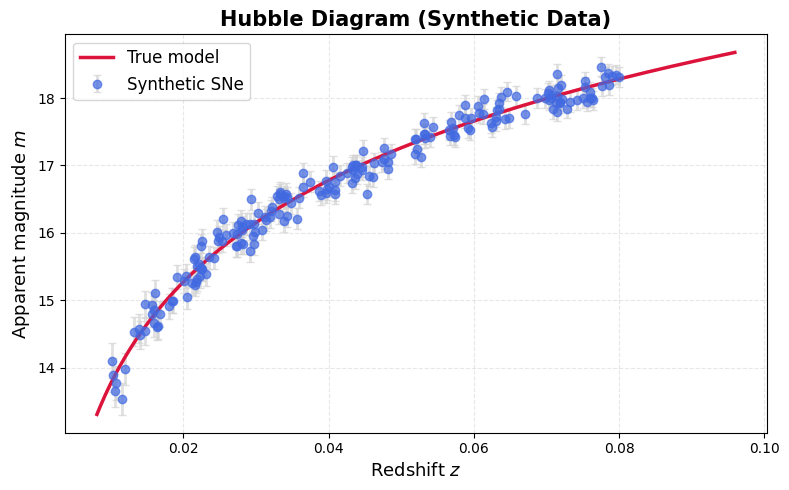

In [3]:
plt.figure(figsize=(8, 5))
plt.errorbar(sn.z, sn.m, yerr=sn.sigma_m, fmt='o', alpha=0.7, color='royalblue', 
             ecolor='lightgray', elinewidth=2, capsize=3, label='Synthetic SNe')
zz = np.linspace(sn.z.min()*0.8, sn.z.max()*1.2, 400)
plt.plot(zz, mag_model(zz, true_H0, true_M), color='crimson', lw=2.5, label='True model')
plt.xlabel('Redshift $z$', fontsize=13)
plt.ylabel('Apparent magnitude $m$', fontsize=13)
plt.title('Hubble Diagram (Synthetic Data)', fontsize=15, fontweight='bold')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## 2a) Frequentist: $\chi^2$ fit for $H_0$ (assuming $M$ is known)

Because $M$ and $H_0$ are degenerate for SN-only data, we first assume $M$ is known from an external calibration (distance ladder). We'll scan over $H_0$, compute $\chi^2$, find the minimum, and take the $\Delta\chi^2=1$ interval as an approximate 68% confidence interval for 1 parameter.

Frequentist best-fit H0 = 73.31 km/s/Mpc
68% CI (Delta chi^2=1): [72.95, 73.69] km/s/Mpc


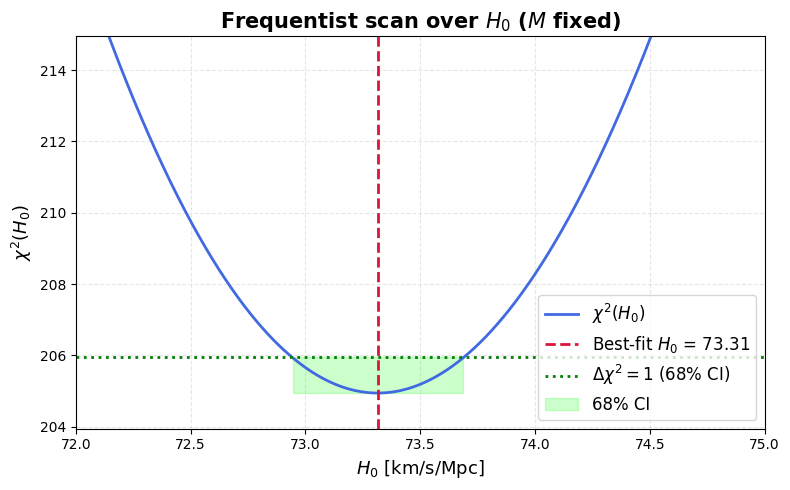

In [4]:
M_known = -19.3  # pretend we know this from a calibrator sample
H0_grid = np.linspace(50, 90, 10000)
H0_best, chi2_vals, Hg = best_fit_H0_given_M(sn, M_known, H0_grid=H0_grid)
H0_min, H0_lo, H0_hi = conf_interval_from_delta_chi2(Hg, chi2_vals, dof=1, delta=1.0)
print(f"Frequentist best-fit H0 = {H0_min:.2f} km/s/Mpc")
print(f"68% CI (Delta chi^2=1): [{H0_lo:.2f}, {H0_hi:.2f}] km/s/Mpc")

plt.figure(figsize=(8, 5))
plt.plot(Hg, chi2_vals, color='royalblue', lw=2, label=r'$\chi^2(H_0)$')
plt.axvline(H0_min, color='crimson', linestyle='--', lw=2, label=fr'Best-fit $H_0$ = {H0_min:.2f}')
plt.axhline(chi2_vals.min()+1.0, color='green', linestyle=':', lw=2, label=r'$\Delta\chi^2=1$ (68% CI)')
plt.fill_betweenx([chi2_vals.min(), chi2_vals.min()+1.0], H0_lo, H0_hi, color='lime', alpha=0.2, label='68% CI')
plt.xlabel(r'$H_0$ [km/s/Mpc]', fontsize=13)
plt.ylabel(r'$\chi^2(H_0)$', fontsize=13)
plt.title(r'Frequentist scan over $H_0$ ($M$ fixed)', fontsize=15, fontweight='bold')
plt.xlim(72, 75)
plt.ylim(chi2_vals.min() - 1, chi2_vals.min() + 10)
plt.grid(True, ls='--', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Residuals and goodness-of-fit checks
With the frequentist best-fit $H_0$ (and fixed $M$), inspect residuals.

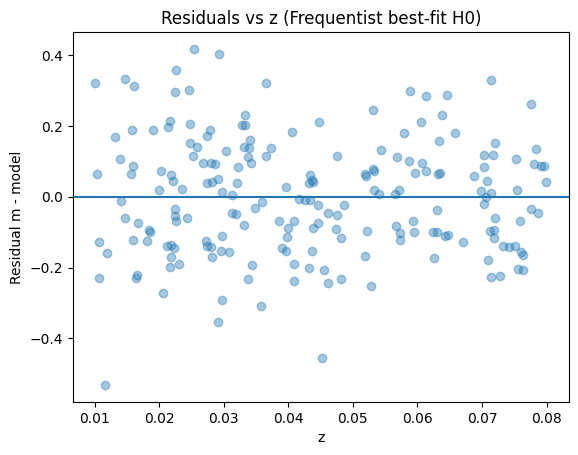

Reduced chi^2 ~ 1.03 (nu=199)
Reduced chi² = 204.94 for ν=1 — is your fit good? (chi²/ν ≈ 1 means a great fit!)


In [5]:
model_best = mag_model(sn.z, H0_min, M_known)
res = sn.m - model_best
plt.figure()
plt.scatter(sn.z, res, alpha=0.4)
plt.axhline(0.0)
plt.xlabel('z')
plt.ylabel('Residual m - model')
plt.title('Residuals vs z (Frequentist best-fit H0)')
plt.show()

nu = len(sn.z) - 1  # 1 parameter (H0) fitted here
chi2_min = np.min(chi2_vals)
print(f"Reduced chi^2 ~ {chi2_min/nu:.2f} (nu={nu})")

nu = 1  # 1 parameter (H0) fitted here
chi2_min = np.min(chi2_vals)
print(f"Reduced chi² = {chi2_min/nu:.2f} for ν={nu} — is your fit good? (chi²/ν ≈ 1 means a great fit!)")

### Bootstrap uncertainty (non-parametric)

We can also estimate the sampling distribution of $\hat H_0$ by bootstrapping SNe with replacement.

Bootstrap median H0 = 73.30 km/s/Mpc
Bootstrap 68% interval: [72.95, 73.70] km/s/Mpc


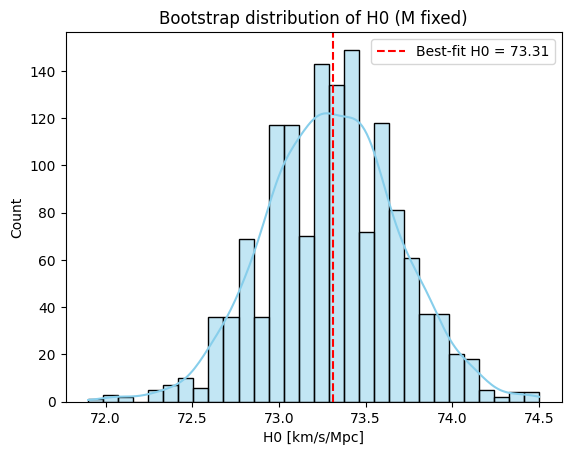

In [6]:
import seaborn as sns

H0_boot = bootstrap_H0(sn, M_known, nboot=1400, rng=42)
h_med = np.median(H0_boot)
h_lo, h_hi = np.percentile(H0_boot, [16, 84])
print(f"Bootstrap median H0 = {h_med:.2f} km/s/Mpc")
print(f"Bootstrap 68% interval: [{h_lo:.2f}, {h_hi:.2f}] km/s/Mpc")

plt.figure()
sns.histplot(H0_boot, bins=30, kde=True, stat="count", color="skyblue", edgecolor="k")
plt.axvline(H0_min, color='r', linestyle='--', label=f'Best-fit H0 = {H0_min:.2f}')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Count')
plt.title('Bootstrap distribution of H0 (M fixed)')
plt.legend()
plt.show()

---
## 2b) Frequentist MLE: joint fit of $(H_0, M)$ with an external calibrator

SN-only data at low $z$ cannot separately determine $H_0$ and $M$; they are (almost) perfectly degenerate. In a frequentist setting, we can include an **external calibrator measurement** of $M$ via a Gaussian constraint (a.k.a. penalty term) and then do **maximum likelihood estimation (MLE)** jointly for $(H_0, M)$.

We minimize
$$ -2\ln\mathcal{L}(H_0, M) = \chi^2_\mathrm{SN}(H_0, M) + \frac{(M-M_\mathrm{cal})^2}{\sigma_M^2}. $$

From the MLE, we compute the **covariance** and **correlation** matrices using a numerical Hessian approximation to the observed Fisher information.

MLE (with calibrator): H0 = 73.315, M = -19.300
Covariance matrix (H0, M):
 [[1.49447333e+00 4.22004580e-02]
 [4.22004580e-02 1.24991310e-03]]
Correlation matrix (H0, M):
 [[1.         0.97641214]
 [0.97641214 1.        ]]


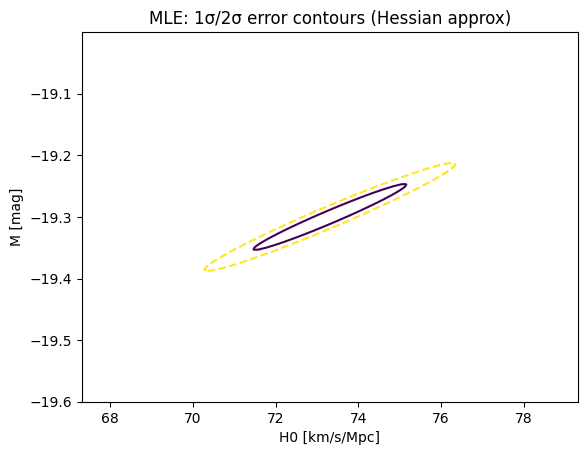

In [7]:
def nll_sn(H0, M, sn):
    # Gaussian -2 log L = chi^2 + const (const dropped)
    return chi2(H0, M, sn)

def nll_total(H0, M, sn, M_cal=-19.3, M_sigma=0.05):
    pen = ((M - M_cal)/M_sigma)**2
    return nll_sn(H0, M, sn) + pen

def nelder_mead_2d(fun, x0, args=(), maxit=2000, tol=1e-6):
    # Minimal Nelder–Mead for 2D without scipy; good enough for smooth problems.
    import numpy as np
    alpha, gamma, rho, sigma = 1.0, 2.0, 0.5, 0.5
    x = np.array(x0, dtype=float)
    # initial simplex
    s = np.array([x, x + np.array([1.0, 0.0]), x + np.array([0.0, 1.0])])
    f = np.array([fun(s[i], *args) for i in range(3)])
    it = 0
    while it < maxit:
        idx = np.argsort(f)
        s, f = s[idx], f[idx]
        best, worst = s[0], s[-1]
        if np.max(np.abs(s - s[0])) < tol and np.max(np.abs(f - f[0])) < tol:
            break
        centroid = (s[0] + s[1])/2.0
        xr = centroid + alpha*(centroid - s[2])
        fr = fun(xr, *args)
        if f[0] <= fr < f[1]:
            s[2], f[2] = xr, fr
        elif fr < f[0]:
            xe = centroid + gamma*(xr - centroid)
            fe = fun(xe, *args)
            if fe < fr:
                s[2], f[2] = xe, fe
            else:
                s[2], f[2] = xr, fr
        else:
            xc = centroid + rho*(s[2] - centroid)
            fc = fun(xc, *args)
            if fc < f[2]:
                s[2], f[2] = xc, fc
            else:
                # shrink
                s[1] = s[0] + sigma*(s[1]-s[0])
                s[2] = s[0] + sigma*(s[2]-s[0])
                f[1] = fun(s[1], *args)
                f[2] = fun(s[2], *args)
        it += 1
    return s[0], f[0]

def num_hessian_2d(fun, x, args=(), eps=1e-4):
    # Central finite-difference Hessian for 2D function
    x = np.array(x, dtype=float)
    e1 = np.array([eps, 0.0])
    e2 = np.array([0.0, eps])
    fpp = fun(x + e1 + e2, *args)
    fpm = fun(x + e1 - e2, *args)
    fmp = fun(x - e1 + e2, *args)
    fmm = fun(x - e1 - e2, *args)
    f00 = fun(x, *args)
    fpp1 = fun(x + e1, *args)
    fmm1 = fun(x - e1, *args)
    fpp2 = fun(x + e2, *args)
    fmm2 = fun(x - e2, *args)
    H11 = (fpp1 - 2*f00 + fmm1)/(eps**2)
    H22 = (fpp2 - 2*f00 + fmm2)/(eps**2)
    H12 = (fpp - fpm - fmp + fmm)/(4*eps**2)
    H = np.array([[H11, H12], [H12, H22]])
    return H

# Run MLE with Gaussian calibrator on M
M_cal, M_sigma = -19.3, 0.05
x_mle, fval = nelder_mead_2d(lambda v, *args: nll_total(v[0], v[1], *args),
                             x0=(70.0, -19.3), args=(sn, M_cal, M_sigma))
H0_mle, M_mle = x_mle
print(f"MLE (with calibrator): H0 = {H0_mle:.3f}, M = {M_mle:.3f}")

# Covariance and correlation from Hessian
H = num_hessian_2d(lambda v, *args: nll_total(v[0], v[1], *args), x_mle, args=(sn, M_cal, M_sigma))
Cov = np.linalg.inv(H)
sig_H0 = np.sqrt(Cov[0,0])
sig_M  = np.sqrt(Cov[1,1])
corr = Cov / np.outer([sig_H0, sig_M], [sig_H0, sig_M])
print("Covariance matrix (H0, M):\n", Cov)
print("Correlation matrix (H0, M):\n", corr)

# 1-sigma error ellipse via Hessian approximation
import matplotlib.pyplot as plt
H0_grid = np.linspace(H0_mle-6, H0_mle+6, 200)
M_grid  = np.linspace(M_mle-0.3, M_mle+0.3, 200)
X, Y = np.meshgrid(H0_grid, M_grid, indexing='xy')
d = np.stack([(X-H0_mle).ravel(), (Y-M_mle).ravel()], axis=0)
quad = np.einsum('ij,jk,ki->i', d.T, H, d).reshape(X.shape)
plt.figure()
cs = plt.contour(X, Y, quad, levels=[2.30, 6.17], linestyles=['solid','dashed'])
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('M [mag]')
plt.title('MLE: 1σ/2σ error contours (Hessian approx)')
plt.show()

## 3) Bayesian analysis on a grid

Now, let's assume that we are solving this problem from a Bayesian approach. We know few things: the model, and some prior information about absolute magnitude $M$. We assume that $H_0$ and $M$ have probability density distributions, s we can now place priors on $(H_0, M)$ and compute the joint posterior on a 2D grid. We'll then marginalize to obtain $p(H_0\,|\,\mathrm{data})$.

Two common scenarios:
1. **Calibrated $M$**: adopt a Gaussian prior for $M$ centered on an external calibration with known uncertainty.
2. **Uncalibrated $M$**: adopt a weak/flat prior on $M$, showing the degeneracy.

Below we demonstrate the *calibrated* case by using a Gaussian prior for $M$ with $\sigma_M=0.05\,\mathrm{mag}$.

Bayesian calibrated case: E[H0] ≈ 73.38 km/s/Mpc
Bayesian 68% HPD ~ [71.65, 75.05] km/s/Mpc


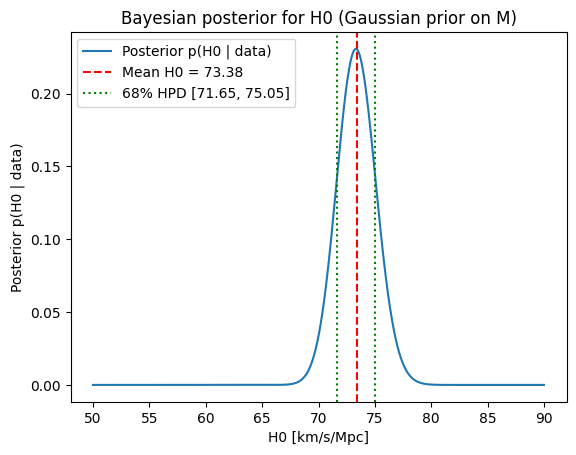

In [8]:
H0_grid = np.linspace(50, 90, 801)
M_grid  = np.linspace(-19.6, -19.0, 601)

M_mean, M_sigma = -19.3, 0.05
def prior_H0(h):
    return 1.0 if (50<=h<=90) else 0.0  # flat within bounds, this is what we call a Uniform prior
def prior_M(m):
    # Gaussian prior (calibrator)
    return np.exp(-0.5*((m-M_mean)/M_sigma)**2)

post = bayes_grid_posterior(sn, H0_grid=H0_grid, M_grid=M_grid,
                            prior_H0=prior_H0, prior_M=prior_M)
pH0 = post['p_H0']/np.trapz(post['p_H0'], H0_grid)
h_lo, h_hi = credible_interval_from_pdf(H0_grid, pH0, alpha=0.68)
h_mean = np.trapz(H0_grid*pH0, H0_grid)
print(f"Bayesian calibrated case: E[H0] ≈ {h_mean:.2f} km/s/Mpc")
print(f"Bayesian 68% HPD ~ [{h_lo:.2f}, {h_hi:.2f}] km/s/Mpc")

plt.figure()
plt.plot(H0_grid, pH0, label='Posterior p(H0 | data)')
plt.axvline(h_mean, color='r', linestyle='--', label=f'Mean H0 = {h_mean:.2f}')
plt.axvline(h_lo, color='g', linestyle=':', label=f'68% HPD [{h_lo:.2f}, {h_hi:.2f}]')
plt.axvline(h_hi, color='g', linestyle=':')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Posterior p(H0 | data)')
plt.title('Bayesian posterior for H0 (Gaussian prior on M)')
plt.legend()
plt.show()

### Inspect the 2D joint posterior


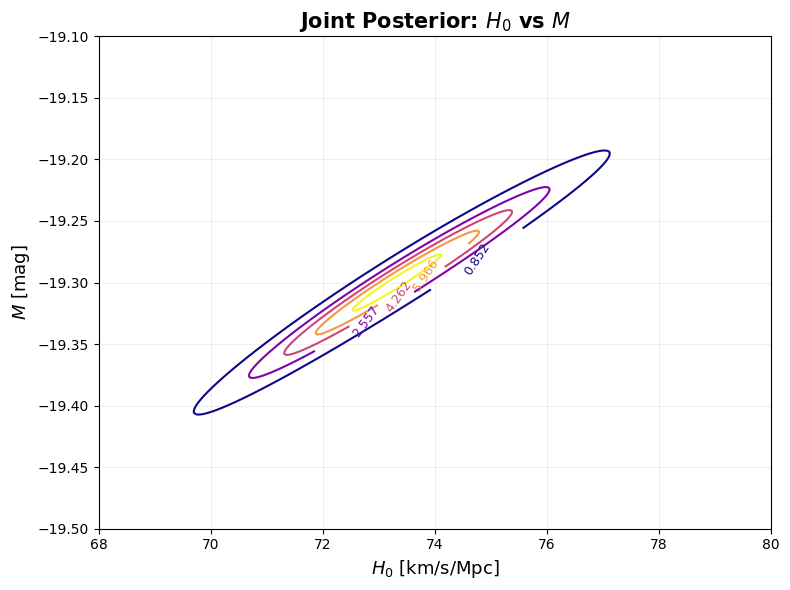

In [9]:
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(H0_grid, M_grid, indexing='xy')
Z = post['post_2d']
cs = plt.contour(X, Y, Z, levels=np.linspace(Z.max()*0.1, Z.max()*0.9, 5), cmap='plasma')
plt.clabel(cs, inline=True, fontsize=9)
plt.xlabel(r'$H_0$ [km/s/Mpc]', fontsize=13)
plt.ylabel(r'$M$ [mag]', fontsize=13)
plt.title('Joint Posterior: $H_0$ vs $M$', fontsize=15, fontweight='bold')
plt.xlim(68, 80)
plt.ylim(-19.5, -19.1)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Optional: uncalibrated $M$ (flat prior) to show degeneracy
Set a broad, nearly flat prior on $M$ and see how the $H_0$ marginal becomes wide.


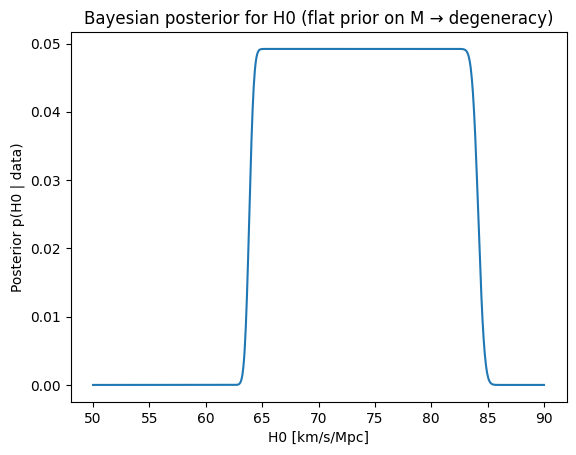

In [10]:
def prior_M_flat(m):
    return 1.0 if (-19.6 <= m <= -19.0) else 0.0
post_uncal = bayes_grid_posterior(sn, H0_grid=H0_grid, M_grid=M_grid,
                                  prior_H0=prior_H0, prior_M=prior_M_flat)
pH0_uncal = post_uncal['p_H0']/np.trapz(post_uncal['p_H0'], H0_grid)
plt.figure()
plt.plot(H0_grid, pH0_uncal)
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Posterior p(H0 | data)')
plt.title('Bayesian posterior for H0 (flat prior on M → degeneracy)')
plt.show()

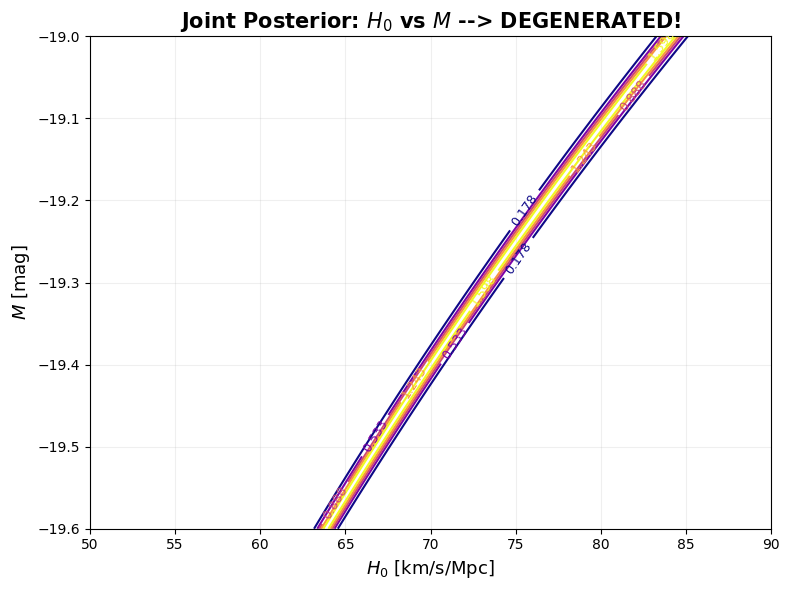

In [11]:
plt.figure(figsize=(8, 6))
X, Y = np.meshgrid(H0_grid, M_grid, indexing='xy')
Z = post_uncal['post_2d']
cs = plt.contour(X, Y, Z, levels=np.linspace(Z.max()*0.1, Z.max()*0.9, 5), cmap='plasma')
plt.clabel(cs, inline=True, fontsize=9)
plt.xlabel(r'$H_0$ [km/s/Mpc]', fontsize=13)
plt.ylabel(r'$M$ [mag]', fontsize=13)
plt.title('Joint Posterior: $H_0$ vs $M$ --> DEGENERATED!', fontsize=15, fontweight='bold')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



## (*) Ideas to follow up!
- Include an intrinsic scatter parameter $\sigma_\mathrm{int}$ and either tune it to make $\chi^2_\nu\approx1$ or infer it with a prior (e.g., Jeffreys prior on a scale).
- Replace the low-$z$ approximation with full $d_L(z; H_0, \Omega_m, \Omega_\Lambda, w,...)$ to use higher-$z$ SNe.
- Incorporate selection effects and Malmquist bias corrections for realistic samples.
- For MCMC instead of a grid, implement a simple Metropolis–Hastings sampler or use a library (e.g., `emcee`) if available in your environment.
